In [37]:
#Install Packages for sentiment analysis

import os
import pandas as pd
from dotenv import load_dotenv
import nltk as nltk
import requests
from pathlib import Path
import datetime as dt
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from newsapi import NewsApiClient
%matplotlib inline

[nltk_data] Downloading package vader_lexicon to C:\Users\Aaron
[nltk_data]     Simpson\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [38]:
# Load dot env and News API key

load_dotenv()
api_key = os.getenv("NEWS_API_KEY")

In [39]:
# Create the newsapi client

newsapi = NewsApiClient(api_key=api_key)

In [65]:
crypto_news = newsapi.get_everything(
    q="Bitcoin AND Ethereum AND 2021 AND 2022",
    language="en"
)

# Show the total number of news
crypto_news["totalResults"]

480

In [41]:
#Create function to display articles in data

def create_df(news, language):
    articles = []
    for article in news:
        try:
            title = article["title"]
            description = article["description"]
            text = article["content"]
            date = article["publishedAt"][:10]

            articles.append({
                "title": title,
                "description": description,
                "text": text,
                "date": date,
                "language": language
            })
        except AttributeError as ae:
            pass

    return pd.DataFrame(articles)

In [42]:
# Create a DataFrame with the news articles
crypto_news_df = create_df(crypto_news["articles"], "en")

In [43]:
#Display Articles
crypto_news_df.head()

,title,description,text,date,language
0,Ethereum and Bitcoin Prices Are Tanking. Here’...,<ol><li>Ethereum and Bitcoin Prices Are Tankin...,Editorial IndependenceWe want to help you make...,2022-05-09,en
1,Bitcoin plunges to lowest price since 2020 ami...,"The ""stablecoin"" Tether briefly lost its peg t...","23 with 16 posters participating, including st...",2022-05-12,en
2,"Bitcoin, cryptocurrency shed $200 billion in o...","<ol><li>Bitcoin, cryptocurrency shed $200 bill...",Contagion spreading to stock markets as invest...,2022-05-12,en
3,Stablecoins are struggling to survive the cryp...,After the Terra stablecoin broke its dollar pe...,"Once pegged to the dollar, Terras UST coin is ...",2022-05-12,en
4,Protecting Retirement Savings from Volatile Cr...,Did you hear? You may be able to allocate some...,Did you hear? You may be able to allocate some...,2022-05-09,en


In [45]:
# Save to CSV
file_path = Path("../Project 3/market_news.csv")
crypto_news_df.to_csv(file_path, index=False, encoding='utf-8-sig')

In [49]:
# Sentiment calculation based on compound score
def get_sentiment(score):
    result = 0  # Neutral by default
    if score >= 0.05:  # Positive
        result = 1
    elif score <= -0.05:  # Negative
        result = -1

    return result

In [56]:
# Sentiment scores dictionaries
title_sent = {
    "title_compound": [],
    "title_pos": [],
    "title_neu": [],
    "title_neg": [],
    "title_sent": [],
}
text_sent = {
    "text_compound": [],
    "text_pos": [],
    "text_neu": [],
    "text_neg": [],
    "text_sent": [],
}

In [57]:
# Get sentiment for the text and the title
for index, row in crypto_news_df.iterrows():
    try:
        # Sentiment scoring with VADER
        title_sentiment = analyzer.polarity_scores(row["title"])
        title_sent["title_compound"].append(title_sentiment["compound"])
        title_sent["title_pos"].append(title_sentiment["pos"])
        title_sent["title_neu"].append(title_sentiment["neu"])
        title_sent["title_neg"].append(title_sentiment["neg"])
        title_sent["title_sent"].append(get_sentiment(title_sentiment["compound"]))

        text_sentiment = analyzer.polarity_scores(row["text"])
        text_sent["text_compound"].append(text_sentiment["compound"])
        text_sent["text_pos"].append(text_sentiment["pos"])
        text_sent["text_neu"].append(text_sentiment["neu"])
        text_sent["text_neg"].append(text_sentiment["neg"])
        text_sent["text_sent"].append(get_sentiment(text_sentiment["compound"]))
    except AttributeError:
        pass

In [59]:
# Attaching sentiment columns to the News DataFrame
crypto_sentiment_df = pd.DataFrame(title_sent)
text_sentiment_df = pd.DataFrame(text_sent)
crypto_news_df = crypto_news_df.join(crypto_sentiment_df).join(text_sentiment_df)

crypto_news_df.head()

,title,description,text,date,language,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent
0,Ethereum and Bitcoin Prices Are Tanking. Here’...,<ol><li>Ethereum and Bitcoin Prices Are Tankin...,Editorial IndependenceWe want to help you make...,2022-05-09,en,-0.5106,0.0,0.777,0.223,-1,0.6908,0.178,0.822,0.000,1
1,Bitcoin plunges to lowest price since 2020 ami...,"The ""stablecoin"" Tether briefly lost its peg t...","23 with 16 posters participating, including st...",2022-05-12,en,-0.3818,0.0,0.776,0.224,-1,-0.3818,0.000,0.925,0.075,-1
2,"Bitcoin, cryptocurrency shed $200 billion in o...","<ol><li>Bitcoin, cryptocurrency shed $200 bill...",Contagion spreading to stock markets as invest...,2022-05-12,en,0.0000,0.0,1.000,0.000,0,-0.5667,0.070,0.757,0.173,-1
3,Stablecoins are struggling to survive the cryp...,After the Terra stablecoin broke its dollar pe...,"Once pegged to the dollar, Terras UST coin is ...",2022-05-12,en,-0.6705,0.0,0.522,0.478,-1,-0.3612,0.000,0.935,0.065,-1
4,Protecting Retirement Savings from Volatile Cr...,Did you hear? You may be able to allocate some...,Did you hear? You may be able to allocate some...,2022-05-09,en,0.0000,0.0,1.000,0.000,0,0.1280,0.045,0.955,0.000,1


<AxesSubplot:title={'center':'News Title and Text Sentiment Comparisson'}>

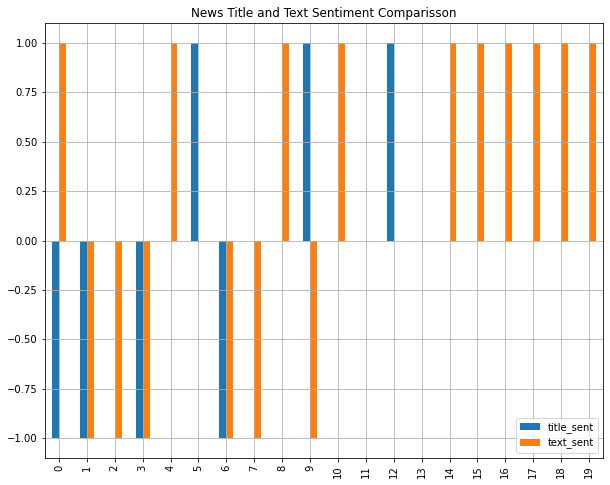

In [64]:
# Plot bar chart
crypto_news_df.plot(
    y=["title_sent", "text_sent"],
    kind="bar",
    title="News Title and Text Sentiment Comparisson",
    figsize=(10, 8),
    grid=True,
)

In [66]:
# Describe dataframe
crypto_news_df.describe()

,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent
count,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,-0.038755,0.036150,0.89450,0.069350,-0.050000,0.113795,0.065750,0.900450,0.033800,0.200000
std,0.292225,0.078957,0.14735,0.139118,0.604805,0.420298,0.067419,0.084541,0.058309,0.894427
min,-0.670500,0.000000,0.52200,0.000000,-1.000000,-0.566700,0.000000,0.727000,0.000000,-1.000000
25%,0.000000,0.000000,0.77675,0.000000,0.000000,-0.148200,0.000000,0.825000,0.000000,-1.000000
50%,0.000000,0.000000,1.00000,0.000000,0.000000,0.064000,0.059500,0.926500,0.000000,0.500000
75%,0.000000,0.000000,1.00000,0.027750,0.000000,0.366350,0.083500,0.951250,0.067500,1.000000
max,0.636900,0.276000,1.00000,0.478000,1.000000,0.827100,0.209000,1.000000,0.173000,1.000000
